In [2]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [7]:
import pickle
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [11]:
snps_names = pd.read_csv('../key_files/var_pos_grenenet.csv')

In [17]:
snps_names = snps_names[snps_names['total_alleles05filter_lastgen'].notna()].reset_index(drop=True)

In [18]:
for run in range(0,12):
    kendall_corr = pd.read_csv(f'kendall_DELTAP_{run}.csv')
    maf = pd.read_csv(f'maf_run{run}.csv')['0']
    kendall_corr = pd.concat([snps_names[['id', 'pos', 'chrom']], kendall_corr, maf],axis=1)
    kendall_corr.columns = ['id', 'pos', 'chrom', 'K_tau', 'K_tau_p', 'MAF']
    kendall_corr['block'] = kendall_corr['id'].map(reverse_mapping) 
    print(kendall_corr['block'].nunique())
    kendall_corr.to_csv(f'kendall_{run}_w_id_n_blocks.csv', index=None)

16665
16665
16665
16665
16665
16665
16665
16665
16665
16665
16665
16665


In [19]:
for run in range(0,12):
    kendall = pd.read_csv(f'kendall_{run}_w_id_n_blocks.csv')
    print(len(kendall))
    print(len(kendall[kendall['MAF'] > 0.01]))

1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048633
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048635
1048634


In [20]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/linages_wza_picmin_last_gen/'

In [21]:
# create sbatch files to submit on cedar server
shfiles = []
for run in range(0,12):
    seed = random.randint(1,100000000)
    file = f'wza_run{run}.sh'
    input = f'kendall_{run}_w_id_n_blocks.csv'
    output = f'wza_run_{run}_results.csv'
    cmd = f'python /carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza/general_WZA_script_mod.py --correlations {input} --summary_stat K_tau_p --window "block" --output {output} --sep ","'
    text = f'''#!/bin/bash
#SBATCH --job-name=wza_run{run}
#SBATCH --time=2:00:00  # 
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=wza_run{run}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/linages_wza_picmin_last_gen
{cmd}

'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

In [22]:
shfiles

['wza_run0.sh',
 'wza_run1.sh',
 'wza_run2.sh',
 'wza_run3.sh',
 'wza_run4.sh',
 'wza_run5.sh',
 'wza_run6.sh',
 'wza_run7.sh',
 'wza_run8.sh',
 'wza_run9.sh',
 'wza_run10.sh',
 'wza_run11.sh']

In [23]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 30498
Submitted batch job 30499
Submitted batch job 30500
Submitted batch job 30501
Submitted batch job 30502
Submitted batch job 30503
Submitted batch job 30504
Submitted batch job 30505
Submitted batch job 30506
Submitted batch job 30507
Submitted batch job 30508
Submitted batch job 30509


In [101]:
wza = pd.read_csv(f'wza_run_{run}_results.csv').reset_index()

In [ ]:
gene - the name of the window
SNPs - the number of SNPs in this window
hits - the number of SNPs in the 99th percentile (not used for anything, just good to know)
Z - the Z score calculated for the gene
top_candidate_p - the result of the top-candidate method of Yeaman et al (2016 - Science)
LA - an indicator of whether the gene is causal for local adaptation
position - the average position of all SNPs in the window
Z_pVal - the p-value of the Z score (This is the WZA score)

In [105]:
biovar = 'bio1'

/tmp/ipykernel_3423978/788878766.py:1: RuntimeWarning: divide by zero encountered in log10
  observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))


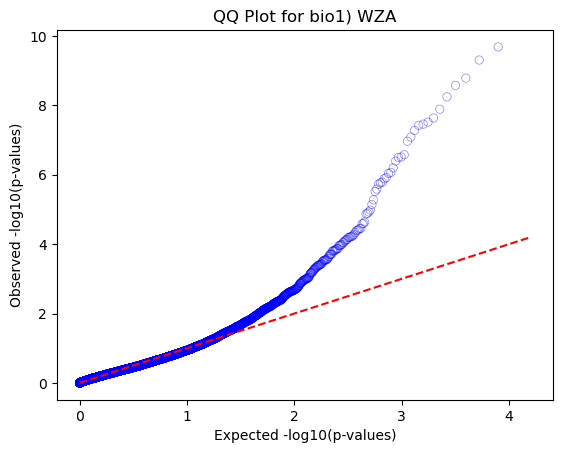

In [106]:
observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza), 1, len(wza)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

In [83]:
import pandas as pd
from collections import defaultdict

num_runs = 12
significant_gene_count = defaultdict(int)  # Dictionary to count significant occurrences of each gene

# Loop through each run and update the count of significant genes
for run in range(num_runs):
    wza = pd.read_csv(f'wza_run_{run}_results.csv').reset_index()
    print(len(wza))
    threshold_value = 0.05 / len(wza)
    
    # Determine significant rows
    significant_rows = wza[wza['Z_pVal'] <= threshold_value]
    
    # Update the count of significant genes
    for gene in significant_rows['gene']:
        significant_gene_count[gene] += 1

# Convert the results to a DataFrame for better readability
significant_gene_df = pd.DataFrame.from_dict(significant_gene_count, orient='index', columns=['sign_count'])
significant_gene_df.index.name = 'Gene'
significant_gene_df = significant_gene_df.reset_index()

# Optionally, save the DataFrame to a CSV file
# significant_gene_df.to_csv('significant_gene_counts.csv', index=False)


16622
16633
16618
16645
16617
16606
16618
16615
16613
16629
16618
16606


In [84]:
wza['chrom'] = wza['gene'].str.split('_').str[0]

In [85]:
wza['chrom'].value_counts()

chrom
1    5100
3    3337
5    3044
4    2997
2    2128
Name: count, dtype: int64

In [ ]:
1    5120
3    3350
5    3058
4    3012
2    2134

In [ ]:
for run in range(num_runs):
    wza = pd.read_csv(f'wza_run{run}_results.csv').reset_index()
    print(len(wza))

In [86]:
significant_gene_df['chrom'] = significant_gene_df['Gene'].str.split('_').str[0]

In [87]:
significant_gene_df.groupby('chrom')['sign_count'].sum()

chrom
1    63
2    32
3    56
4    38
5    40
Name: sign_count, dtype: int64

In [88]:
significant_gene_df.sort_values('sign_count')

,Gene,sign_count,chrom
97,5_1947,1,5
124,1_4788,1,1
125,2_1443,1,2
126,3_1959,1,3
127,3_2439,1,3
...,...,...,...
86,5_918,3,5
68,4_2808,3,4
46,3_518,3,3
29,3_951,3,3


In [89]:
significant_gene_df

,Gene,sign_count,chrom
0,1_1040,2,1
1,1_1761,1,1
2,1_2303,1,1
3,1_4894,2,1
4,1_698,1,1
...,...,...,...
190,4_2293,1,4
191,5_1603,1,5
192,5_17,1,5
193,5_314,1,5


In [90]:
import seaborn as sns

<Axes: xlabel='Gene', ylabel='sign_count'>

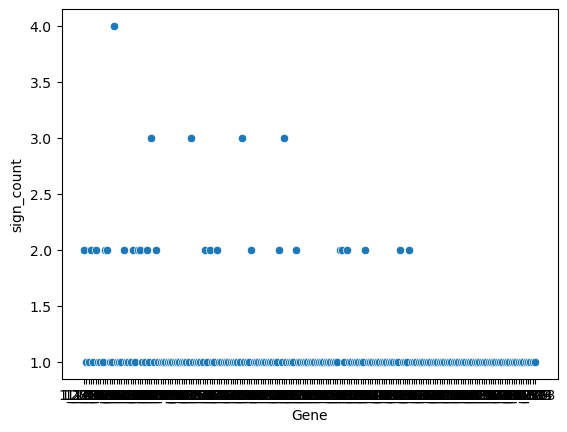

In [91]:
sns.scatterplot(significant_gene_df, x = 'Gene', y = 'sign_count')

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero enco

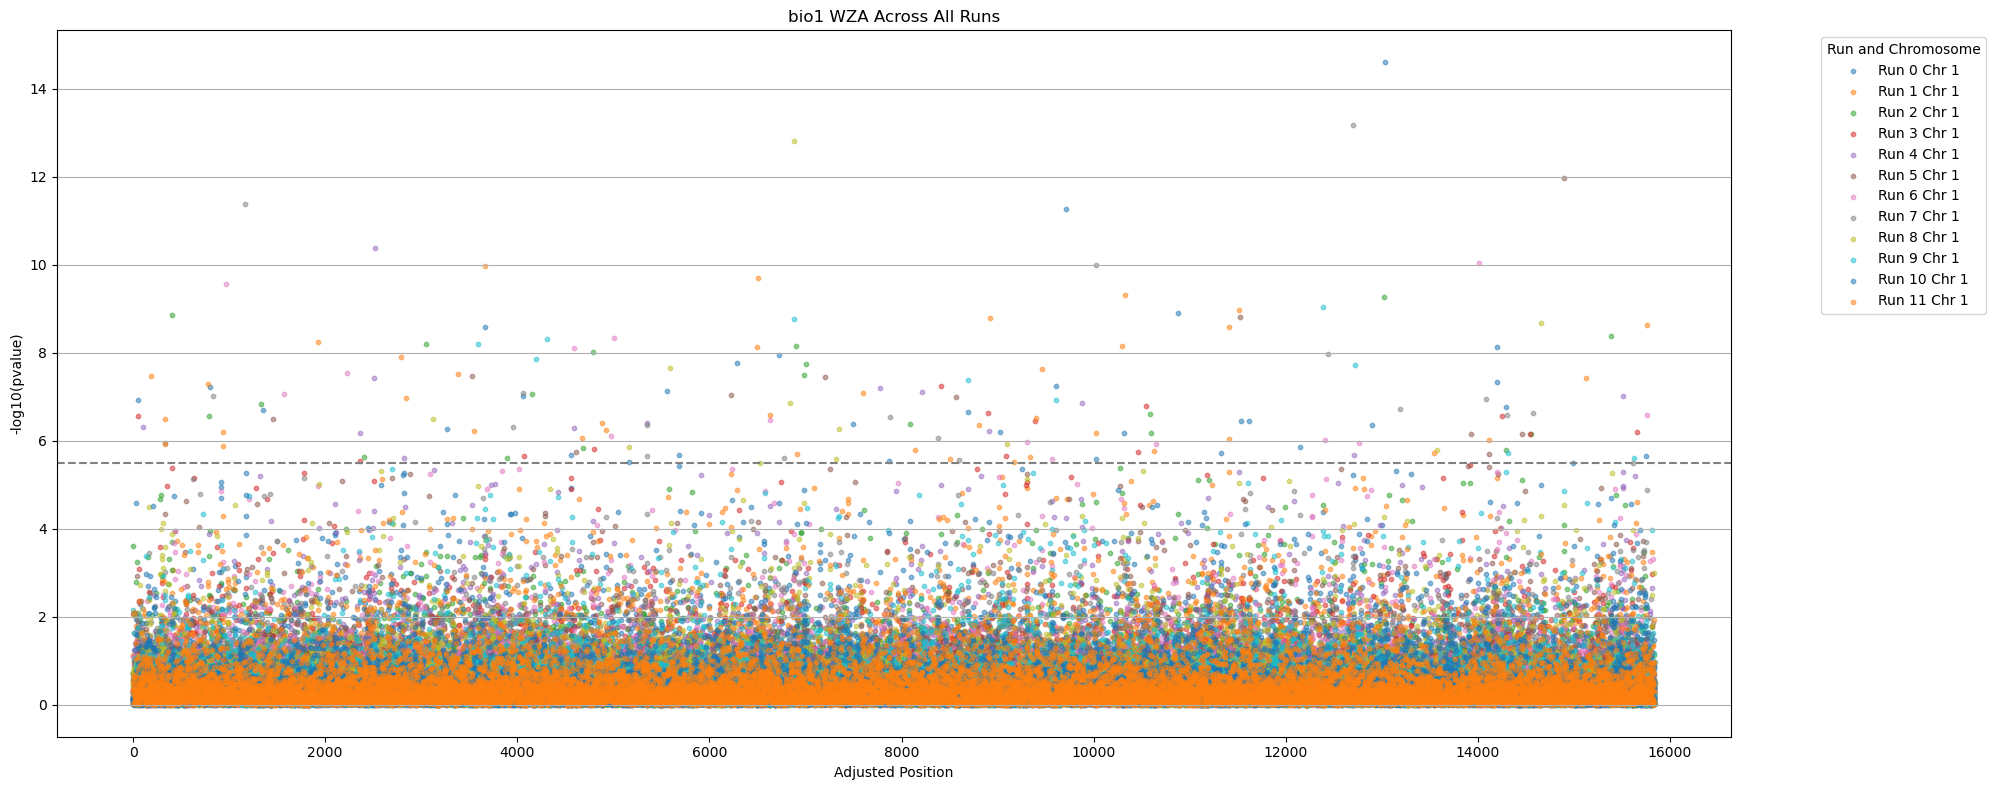

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Number of runs
num_runs = 12

# Create a figure
plt.figure(figsize=(20, 8))

# Colors for chromosomes
colors = sns.color_palette("crest", n_colors=5)

# Loop through each run and plot
for run in range(num_runs):
    wza = pd.read_csv(f'wza_run{run}_results.csv').reset_index()
    threshold_value = 0.05 / len(wza)
    biovar = 'bio1'

    df = wza[['Z_pVal', 'index']].copy()

    # Parsing chromosome number and position
    df['chromosome'] = 1
    df['position'] = df['index']
    df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

    # Calculate the offset for each chromosome to prevent overlap
    chromosome_offsets = {}
    offset = 0
    for chrom in sorted(df['chromosome'].unique()):
        chromosome_offsets[chrom] = offset
        max_position = df[df['chromosome'] == chrom]['position'].max()
        offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

    # Apply offsets to positions
    df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

    # Plotting each run on the same plot
    for chrom in sorted(df['chromosome'].unique()):
        subset = df[df['chromosome'] == chrom]
        plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], label=f'Run {run} Chr {chrom}', s=10, alpha=0.5)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} WZA Across All Runs')
plt.legend(title="Run and Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

# Threshold line (optional)
threshold_value = 0.05 / len(wza)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
# plt.savefig('all_runs_manhattan_overlayed.png')
plt.show()


/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3423978/1395854108.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3423978/1395854108.py:33: UserWarning: *c* argument looks 

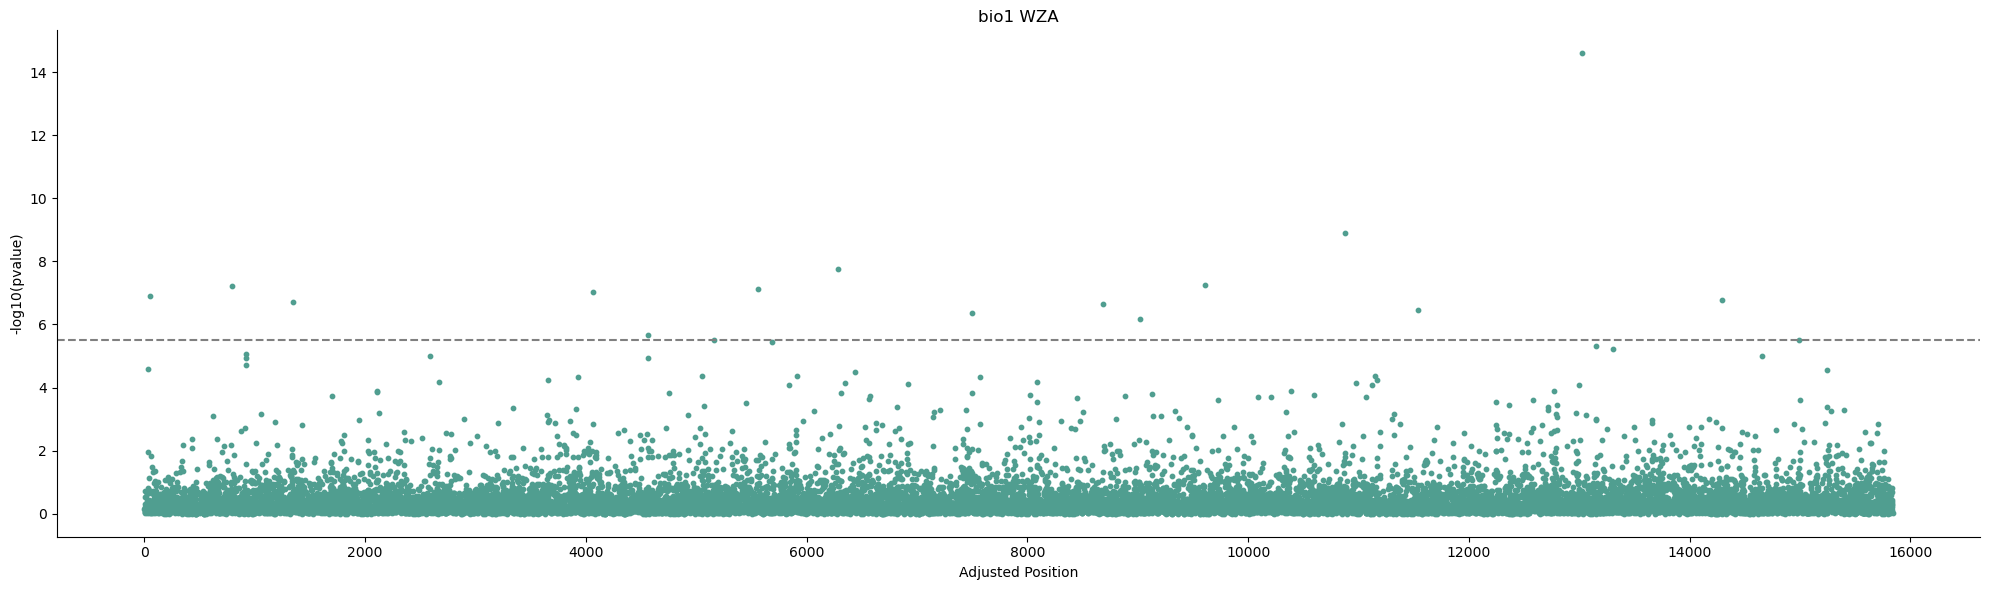

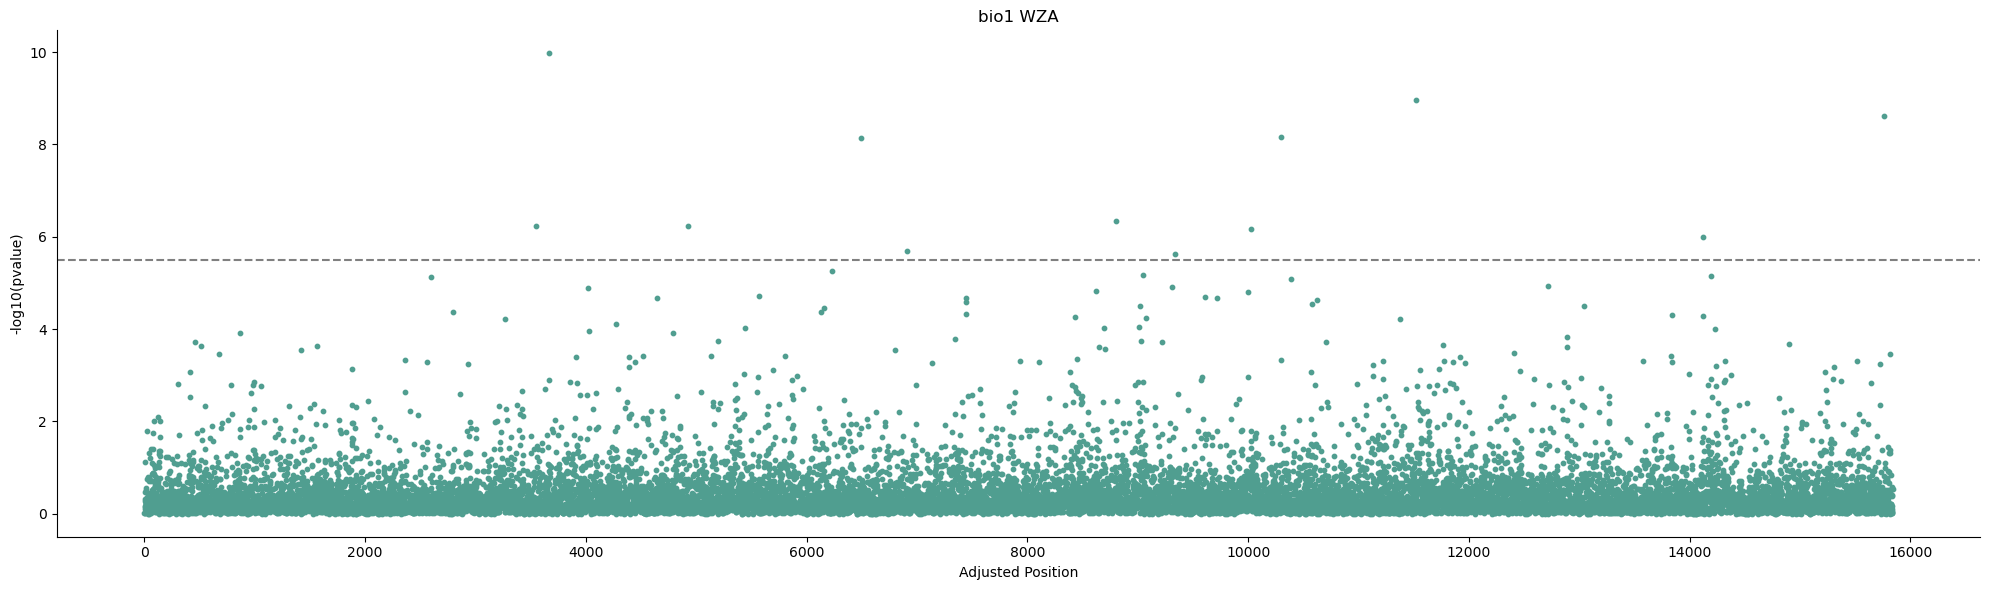

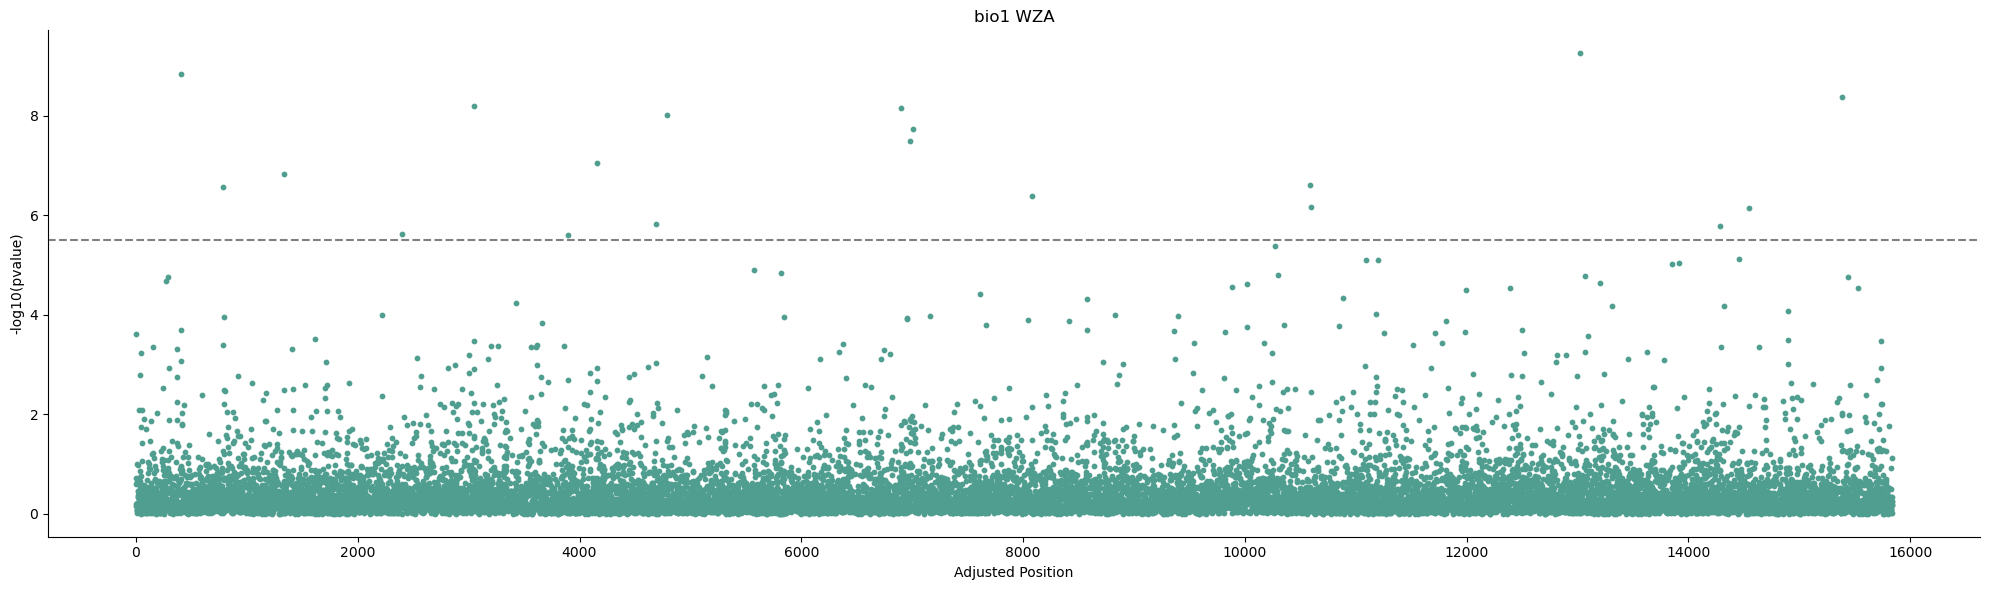

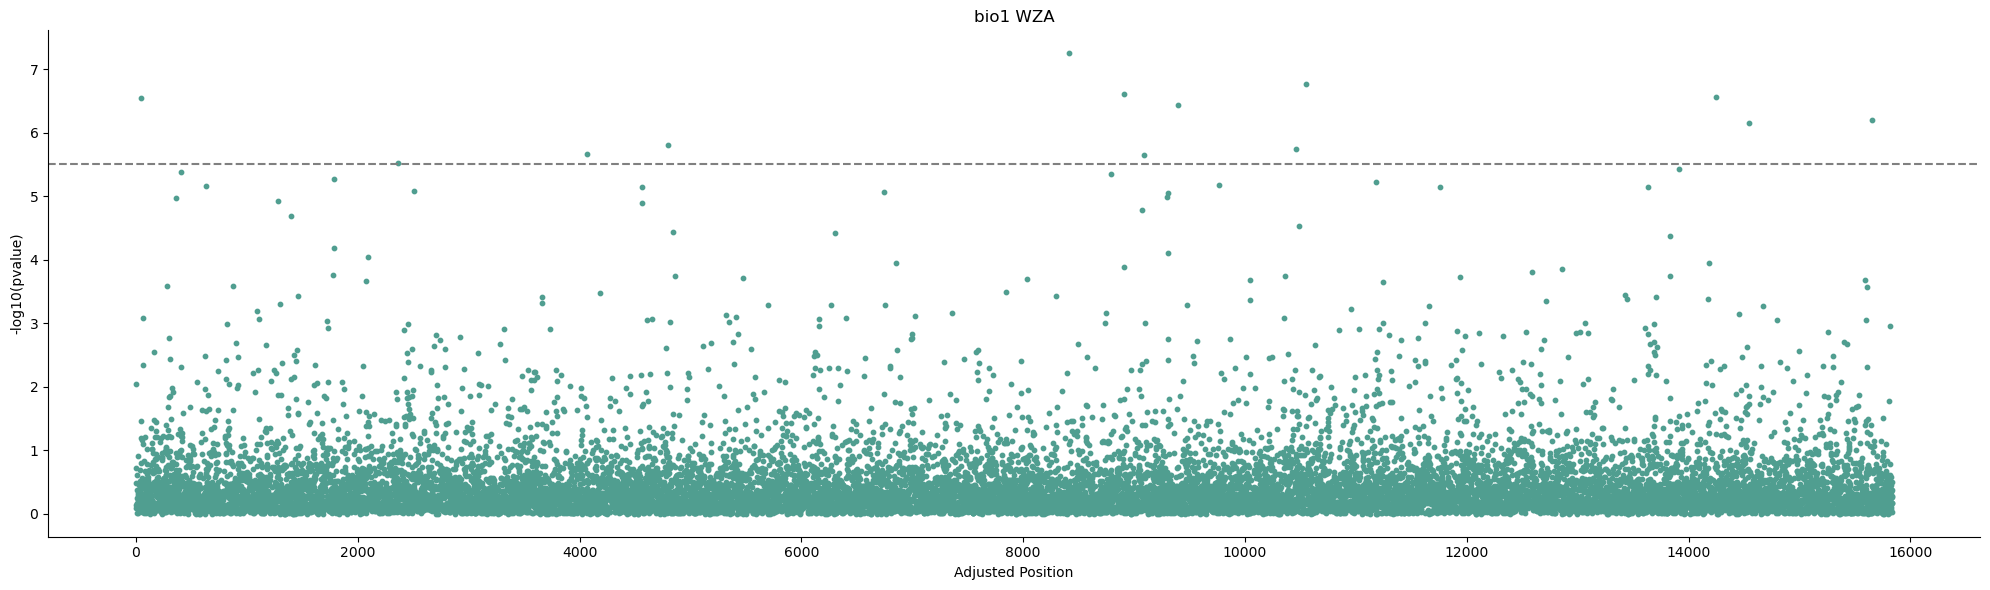

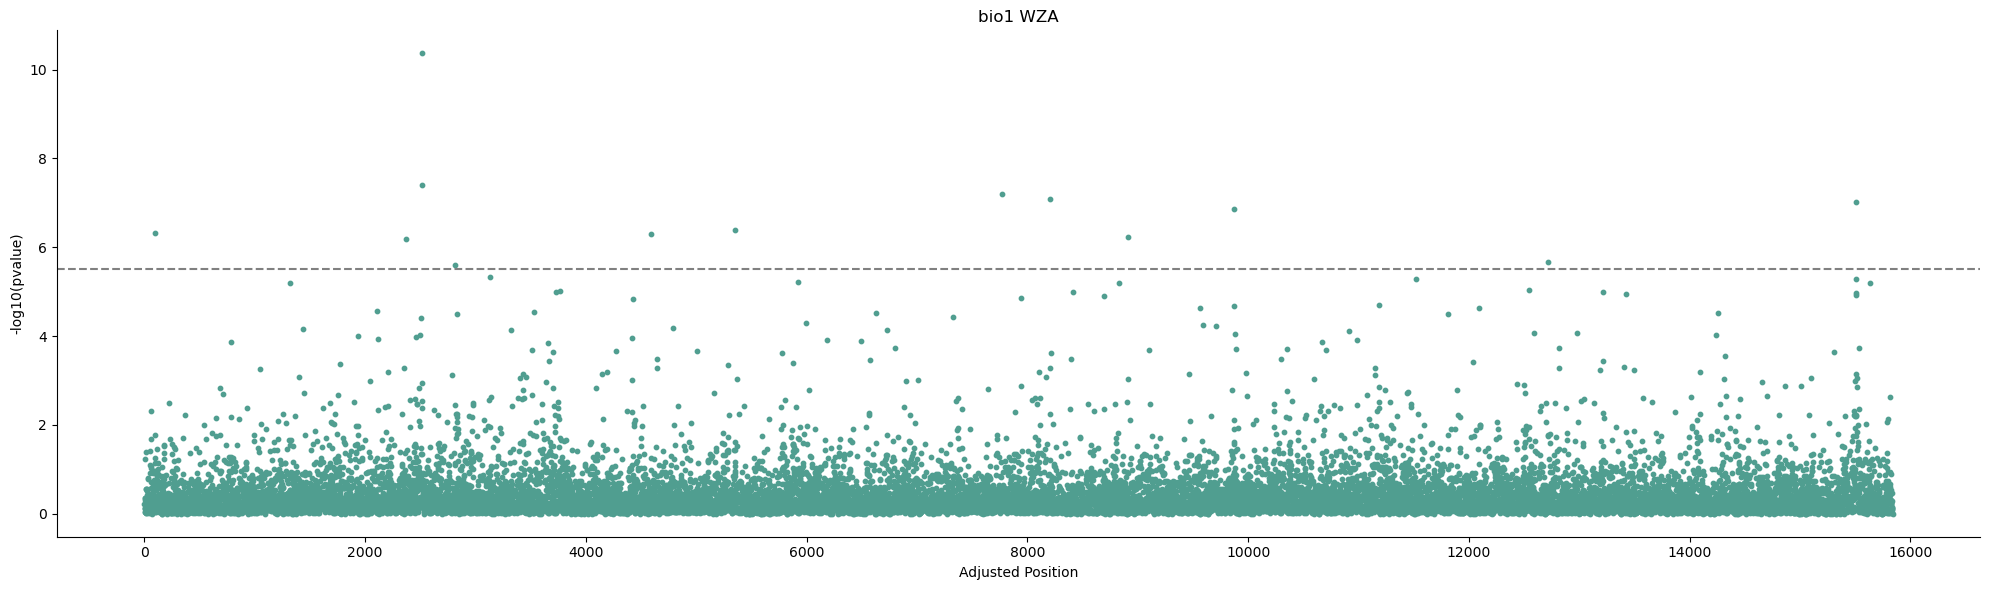

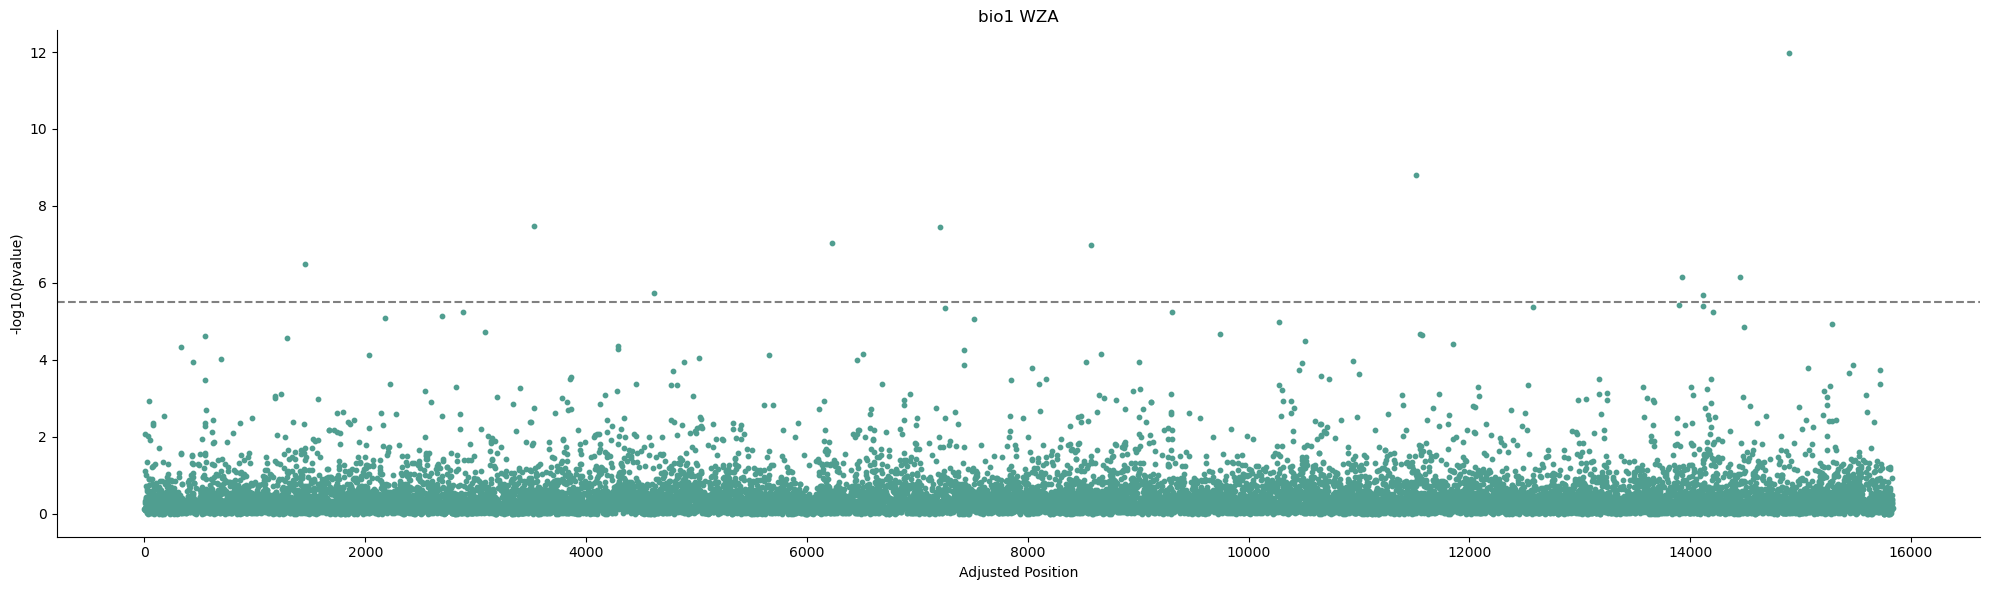

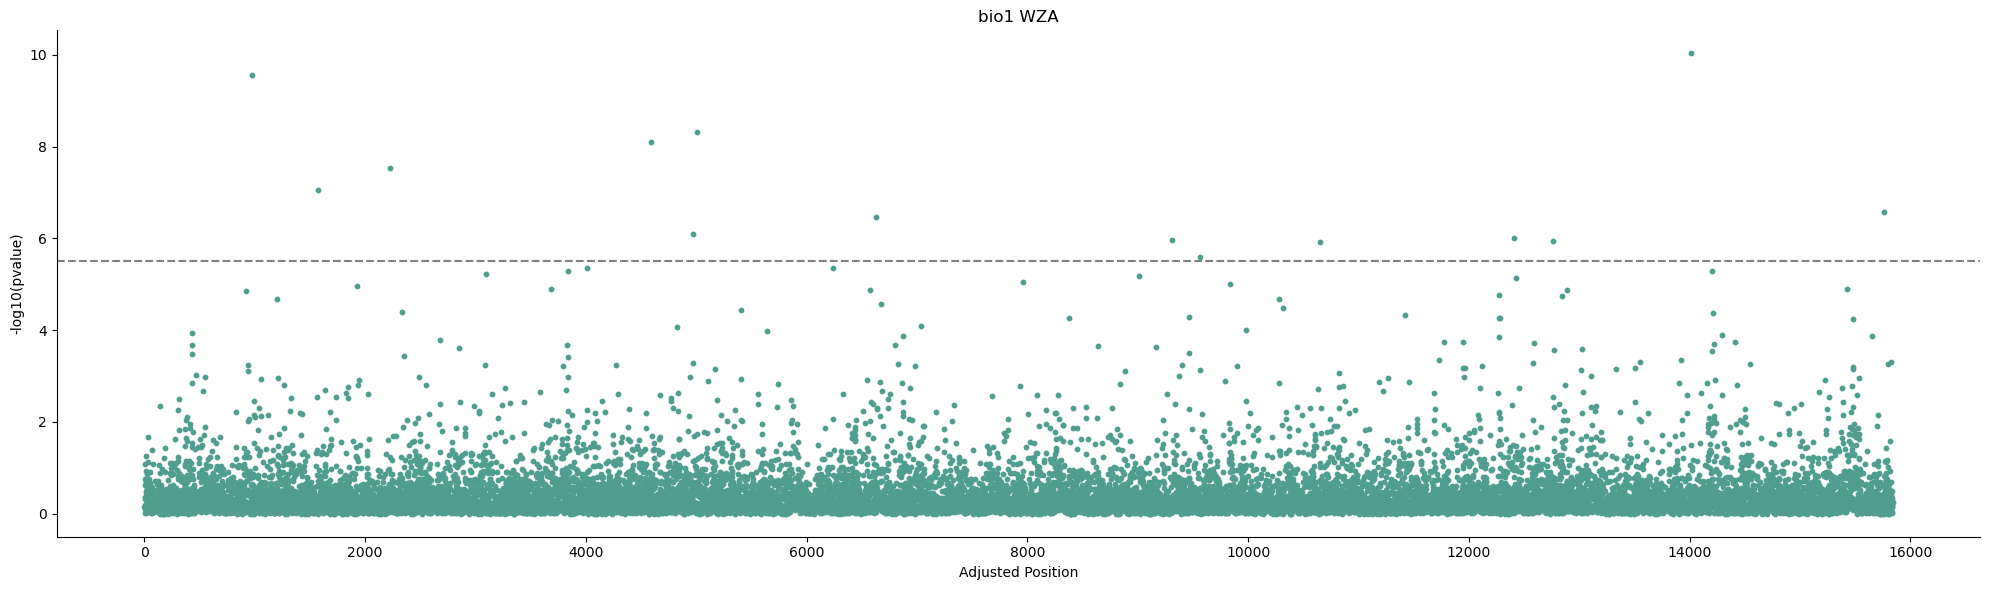

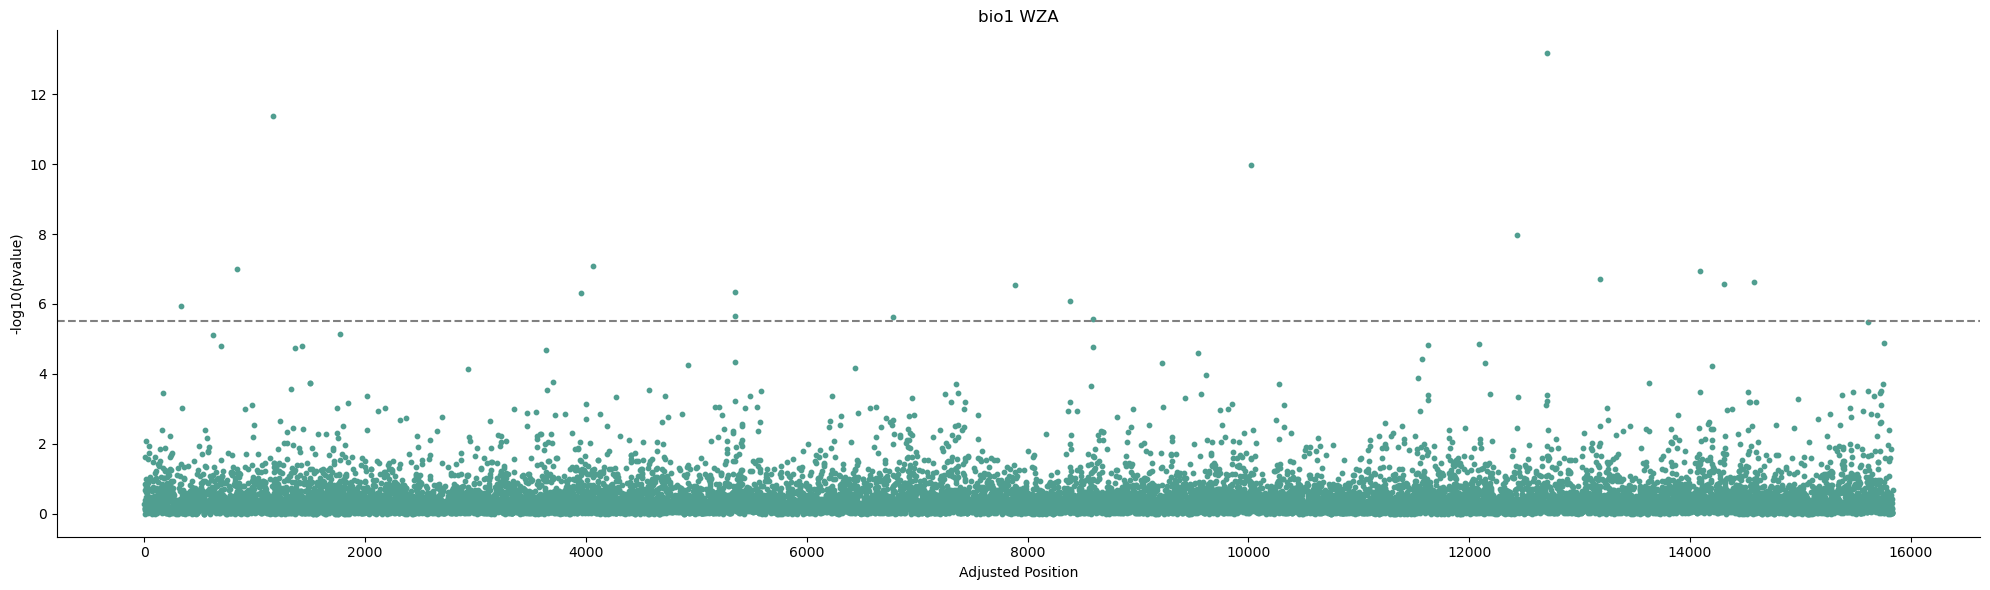

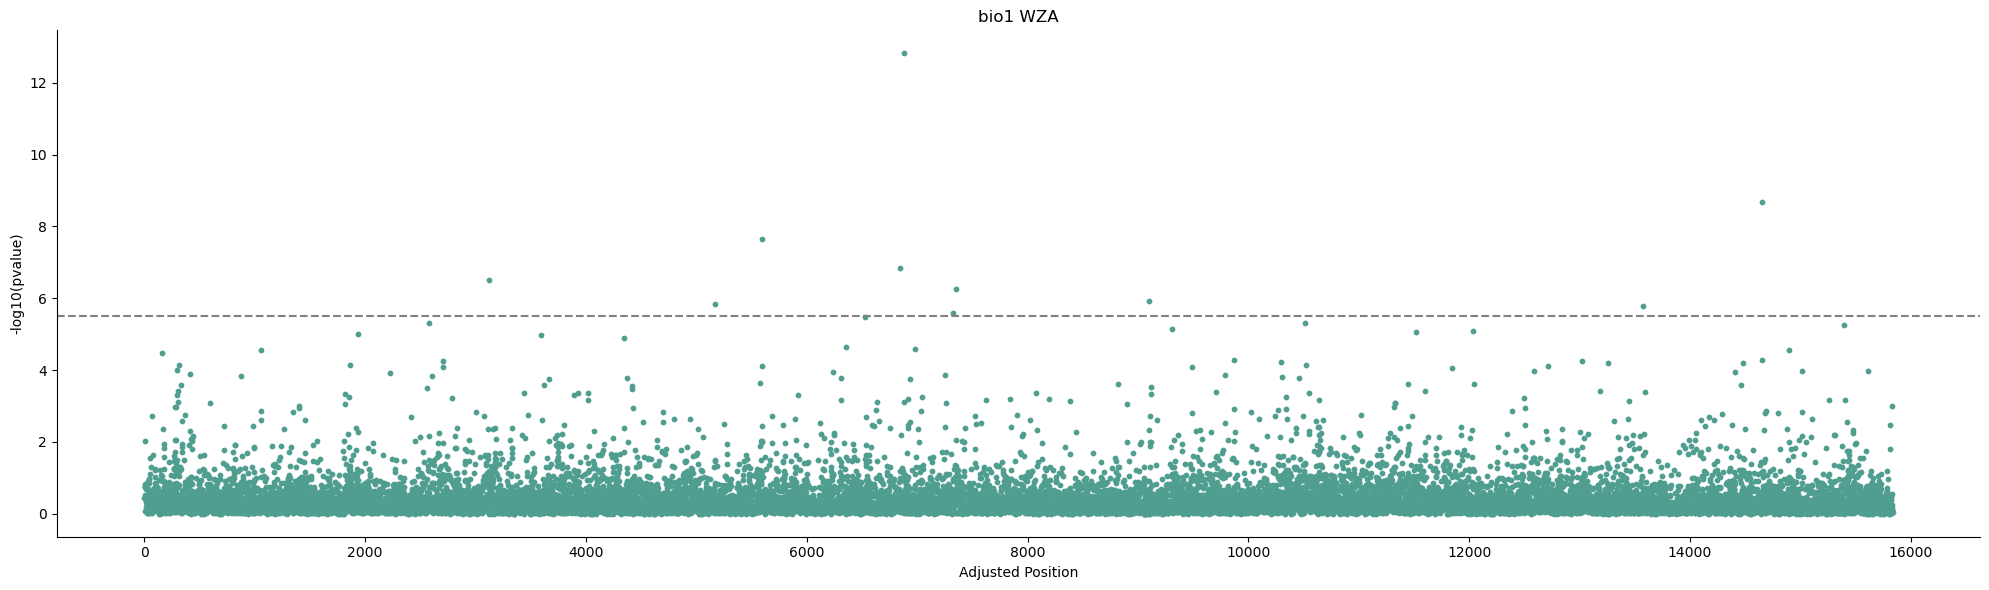

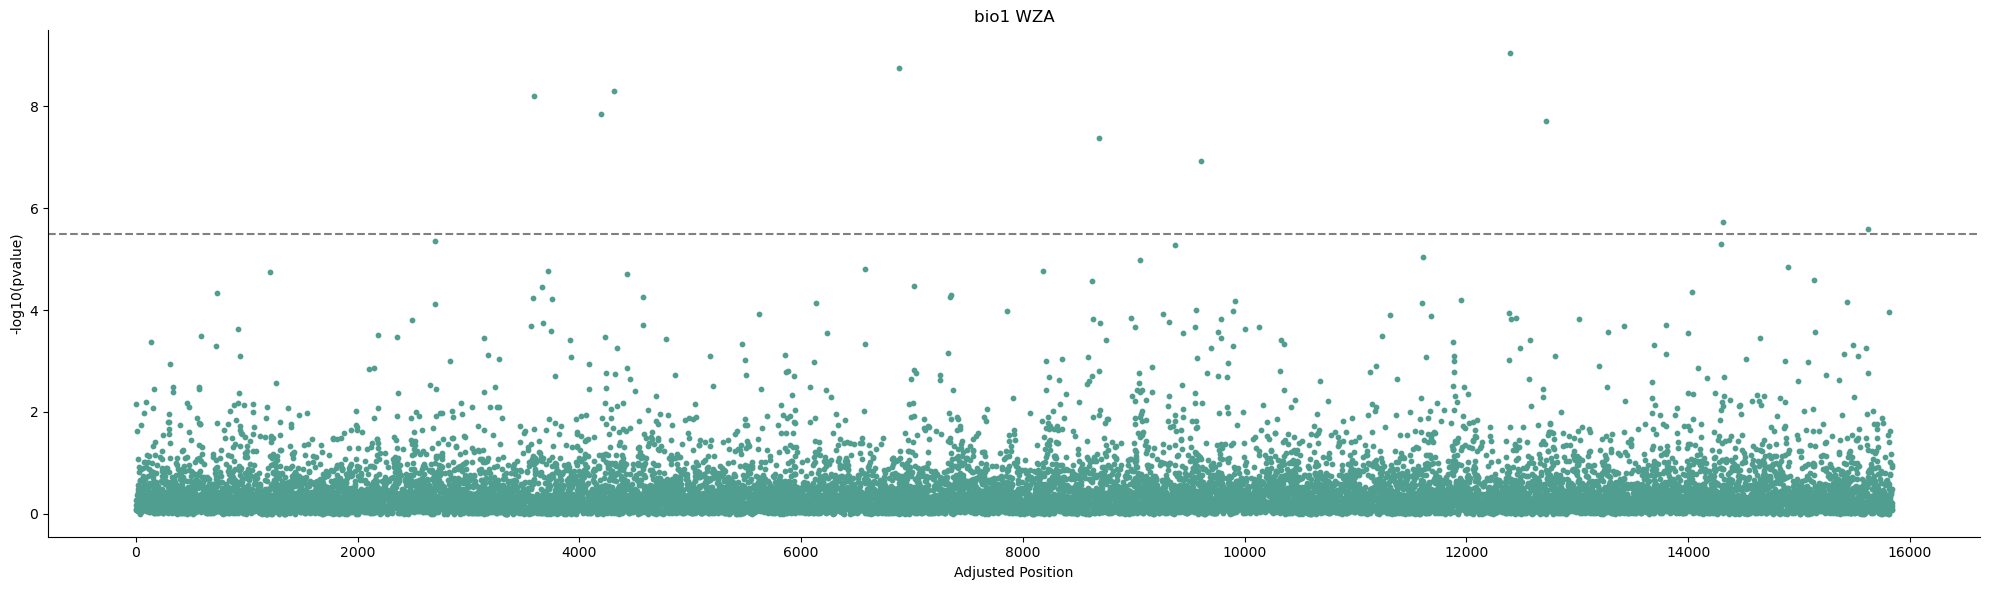

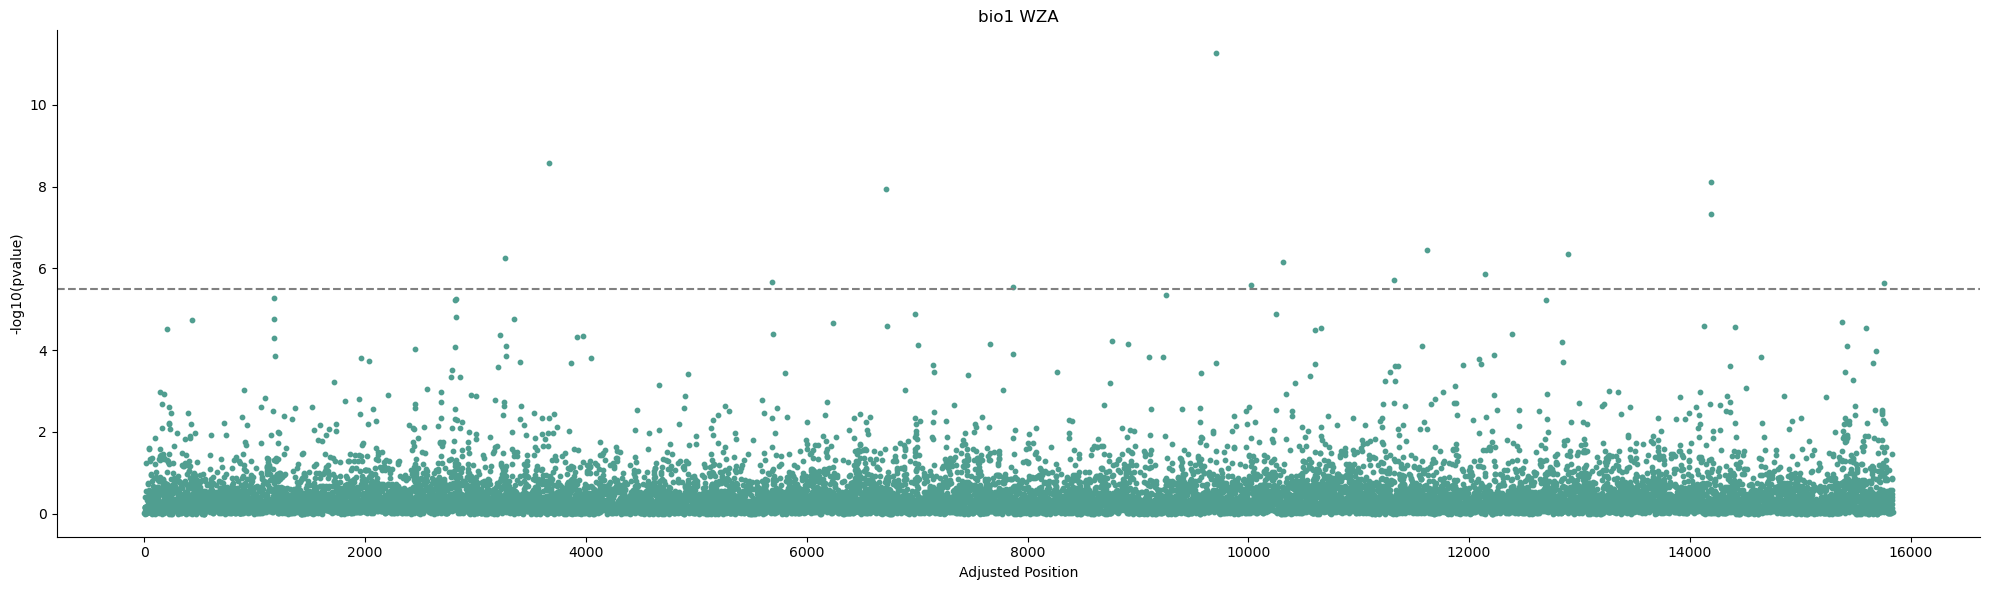

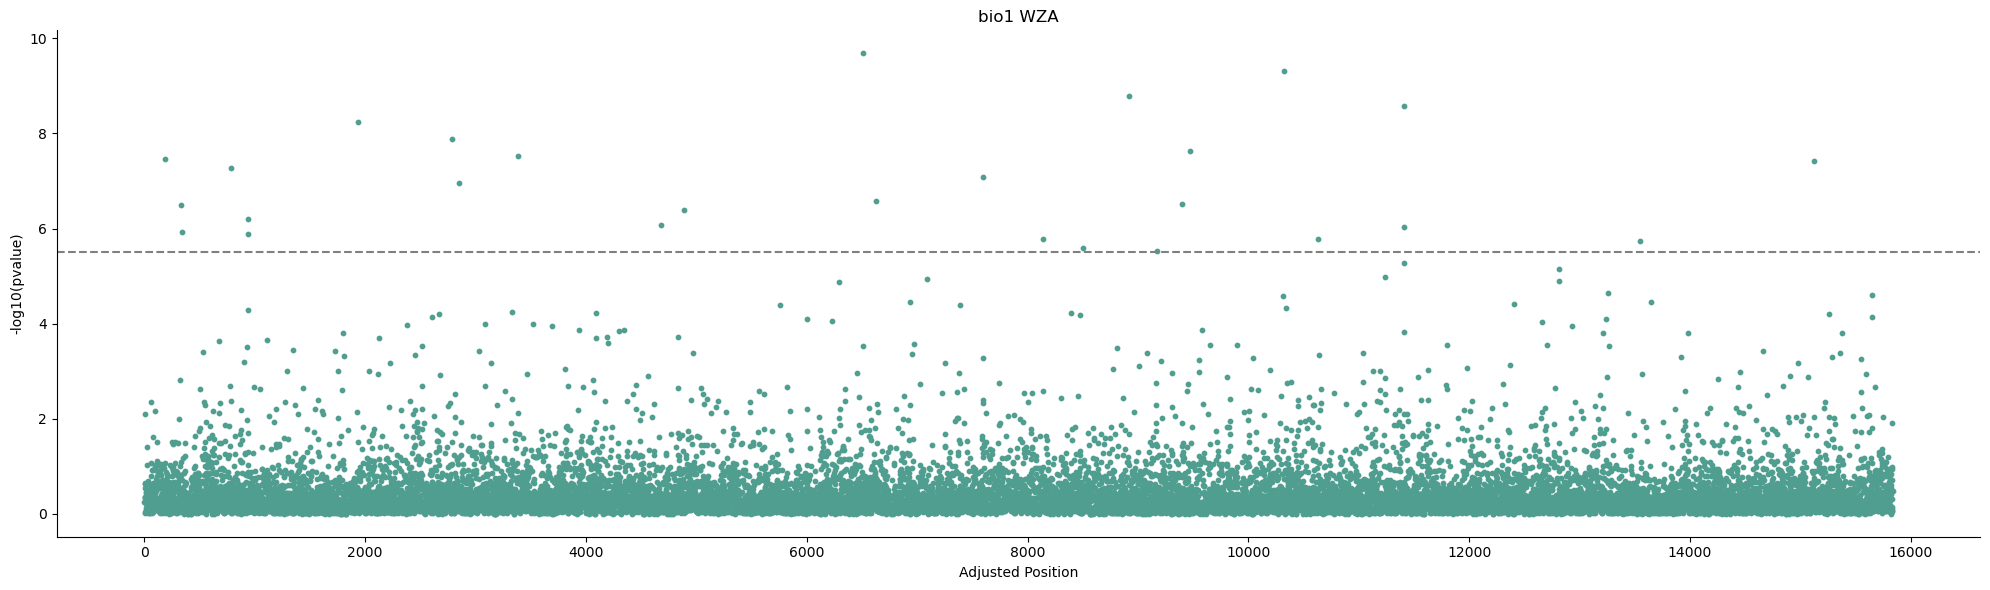

In [72]:
for run in range(0,12):
    wza = pd.read_csv(f'wza_run{run}_results.csv').reset_index()
    threshold_value = 0.05 / len(wza)
    biovar='bio1'
    #sm.qqplot(pvalues['pvalue'], line ='45') 
    #py.show() 
    
    df = wza[['Z_pVal', 'index']].copy()
    
    colors = sns.color_palette("crest", n_colors = 5)
    
    # Parsing chromosome number and position
    df['chromosome'] = 1
    df['position'] = df['index']
    df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])
    
    # Calculate the offset for each chromosome to prevent overlap
    chromosome_offsets = {}
    offset = 0
    for chrom in sorted(df['chromosome'].unique()):
        chromosome_offsets[chrom] = offset
        max_position = df[df['chromosome'] == chrom]['position'].max()
        offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes
    
    # Apply offsets to positions
    df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)
    
    # Creating the Manhattan plot
    plt.figure(figsize=(20, 6))
    
    for chrom in sorted(df['chromosome'].unique()):
        subset = df[df['chromosome'] == chrom]
        plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)
    
    # Aesthetics
    plt.xlabel('Adjusted Position')
    plt.ylabel('-log10(pvalue)')
    #plt.title('Manhattan Plot')
    #plt.grid(axis='y')
    #plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)
    # Threshold line (optional)
    threshold = -np.log10(threshold_value)
    plt.axhline(y=threshold, color='grey', linestyle='dashed')
    plt.title(f'{biovar} WZA')  # Set the title
    
    # Show the plot
    plt.tight_layout()
    #plt.savefig(f'manhattan_{biovar}.png')
plt.show()

/tmp/ipykernel_3423978/2368688080.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


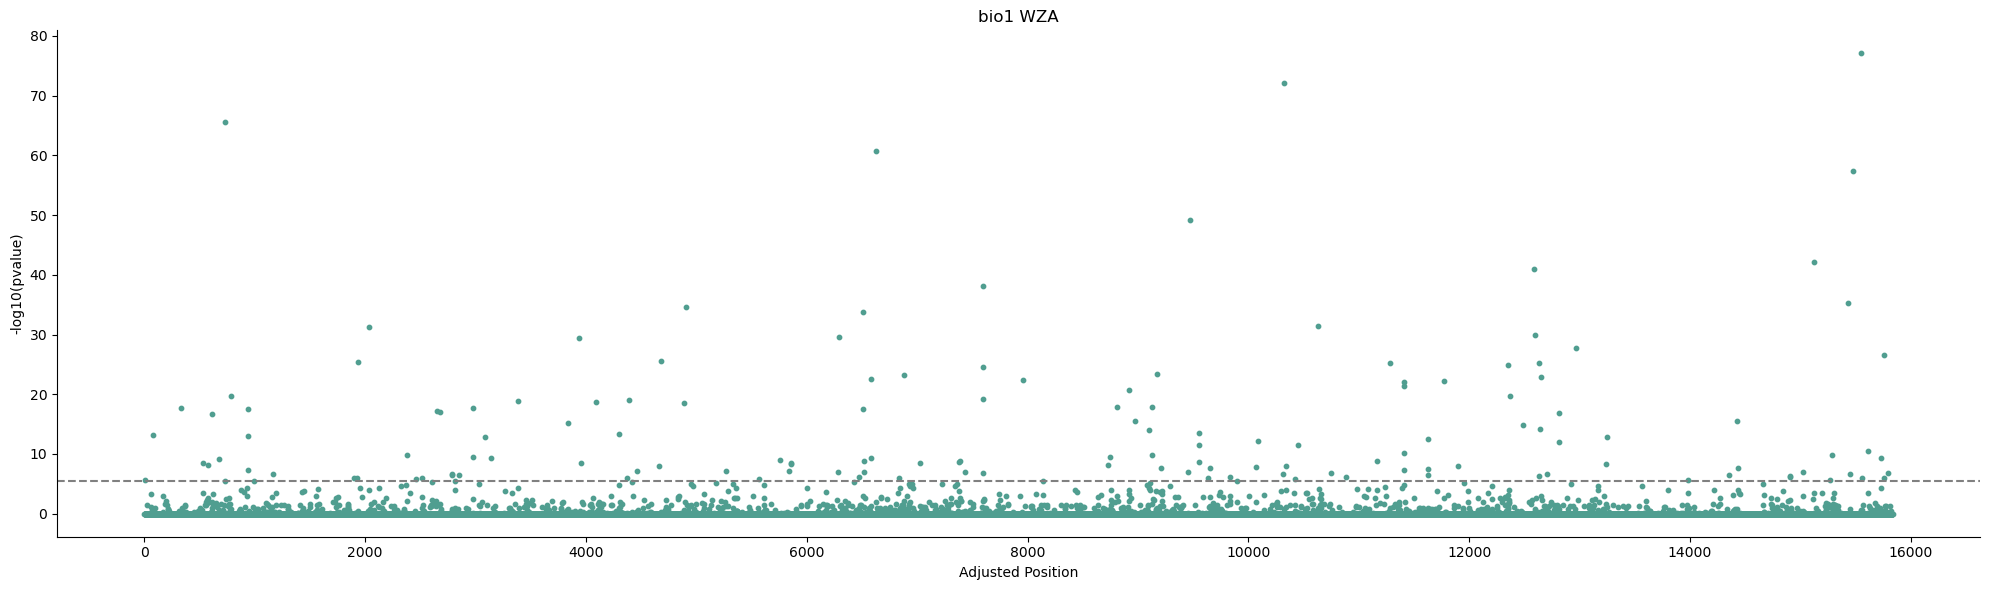

In [61]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['top_candidate_p', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_{biovar}.png')
plt.show()